Here we will build prediction model based on the data produced at the ETL stage. We will compare:
- naive baseline, simply a mean of y_train
- baseline, which will be a linear model based on 1 feature "number_of_panels_total"
- linear model with all the rest features + regularisation 
- linear model with all features + polynomial features + regularisation 
- random forest
- adaboost
- xgboost
- ensamble of best models

In [122]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import ElasticNet

# Data initiation

In [83]:
df = pd.read_csv('datasets/modeling_df.csv')
all_feats = [
    'lat_max',
    'lat_min',
    'long_max',
    'long_min',
    'number_of_panels_north',
    'number_of_panels_south',
    'number_of_panels_east',
    'number_of_panels_west',
    'number_of_panels_flat',
    'number_of_panels_total',
    'lat_mean',
    'long_mean',
    'zip_area',
    'dens',
    'approx_zips',
    'is_usa',
    'zip_lat',
    'zip_long',
    'state_size',
    'state_lat',
    'state_long'
]
label = 'potential_kwh_total'

In [84]:
for col in all_feats:
    print(col, df[col].isna().sum())

lat_max 0
lat_min 0
long_max 0
long_min 0
number_of_panels_north 0
number_of_panels_south 0
number_of_panels_east 0
number_of_panels_west 0
number_of_panels_flat 0
number_of_panels_total 0
lat_mean 0
long_mean 0
zip_area 0
dens 0
approx_zips 0
is_usa 0
zip_lat 0
zip_long 0
state_size 0
state_lat 0
state_long 0


In [85]:
df['is_usa'].unique()

array([50,  0])

# Naive baseline

In [245]:
X_train, X_test, y_train, y_test = train_test_split(df[['number_of_panels_total']].values, df[[label]].values, test_size=.2)
y_pred = np.array([y_train.mean()] * y_test.shape[0])

In [248]:
naive_baseline_rmse = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_test))
naive_baseline_rmse

66.47574234914238

In [250]:
np.std(df[label]) / naive_baseline_rmse

0.9937566187037065

# Baseline

In [111]:
X_train, X_test, y_train, y_test = train_test_split(df[['number_of_panels_total']].values, df[[label]].values, test_size=.2)
baseline_model = linear_model.LinearRegression(positive=True)
y_pred = baseline_model.fit(X_train, y_train).predict(X_test)

In [112]:
baseline_rmse = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_test))
baseline_rmse

10.765679645436233

In [91]:
np.std(df[label]) / baseline_rmse

5.947396230786602

In [92]:
iqr = df[label].quantile(.75) - df[label].quantile(.25)
iqr / baseline_rmse

7.850873823229827

In [93]:
r2_score(y_pred=y_pred, y_true=y_test)

0.9727162984542326

Baseline model is much better, than naive baseline and is only about 17% of label std, about 13% of iqr and very high r2 score. It will probably be hard to beat.

# Linear model + regularisation

In [141]:
X_train, X_test, y_train, y_test = train_test_split(df[all_feats].values, df[[label]].values, test_size=.2)
baseline_model = ElasticNet()
baseline_model.fit(X_train, y_train)
y_pred = baseline_model.predict(X_test)

In [142]:
rmse = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_test))
rmse

9.272368408374703

In [117]:
r2_score(y_pred=y_pred, y_true=y_test)

0.9843561548993689

Interesting, so we managed to beat the baseline model with a regularised linear model. Let's see what features helped the most.

<AxesSubplot: ylabel='0'>

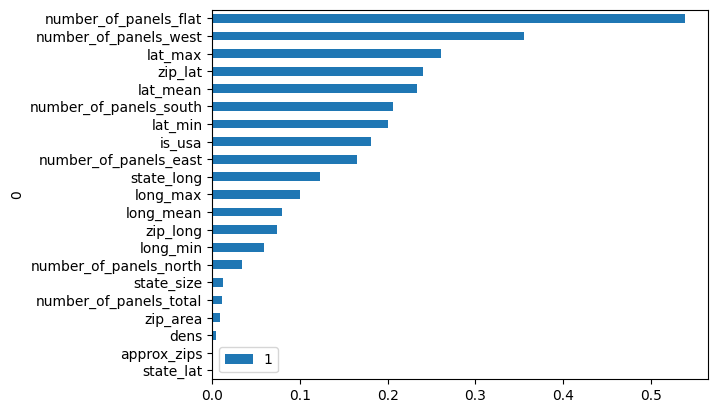

In [121]:
pd.DataFrame(zip(all_feats, baseline_model.coef_)).set_index(0).abs().sort_values(1).plot(kind='barh')

# Linear model + regularisation + polinomial features

In [234]:
poly = PolynomialFeatures(3)
poly_data = poly.fit_transform(df[all_feats])

In [235]:
poly_data.shape

(11490, 2024)

In [236]:
X_train, X_test, y_train, y_test = train_test_split(poly_data, df[[label]].values, test_size=.2)
baseline_model = ElasticNet()
baseline_model.fit(X_train, y_train)
y_pred = baseline_model.predict(X_test)

/Users/igorchebuniaev/.local/share/virtualenvs/RL_in_ksp--361CVkw/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.376e+04, tolerance: 3.970e+03
  model = cd_fast.enet_coordinate_descent(


In [237]:
rmse = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_test))
rmse

3.4606876980350507

In [238]:
r2_score(y_pred=y_pred, y_true=y_test)

0.9973634774912307

Score is improved further by adding polinomial features. Let's look at the feature importance graph again

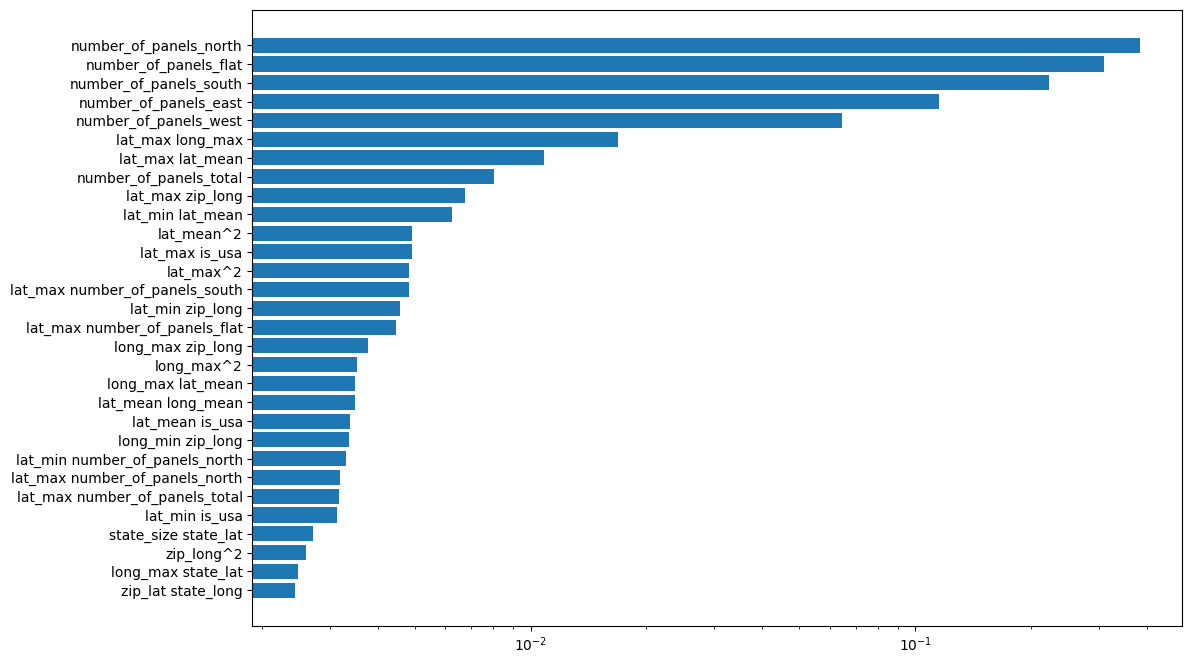

In [239]:
plt.figure(figsize=[12,8])
feat_imp_df = pd.DataFrame(zip(poly.get_feature_names_out(), baseline_model.coef_)).set_index(0).abs().sort_values(1, ascending=False)[:30].sort_values(1)
plt.barh(feat_imp_df.index, feat_imp_df[1])
plt.xscale('log')